# Biodiversity Intactness Index change in Phoenix, AZ
### Author: Lucian Scher
### Date: 12/11/2025
### [Github Repository](https://github.com/lucianbluescher/Phoenix_BII_Change)

## About

This notebook analyzes changes in biodiversity intactness in the Phoenix, Arizona subdivision between 2017 and 2020 using the Biodiversity Intactness Index (BII) from Microsoft's Planetary Computer. The analysis quantifies the loss of high-quality habitat (BII ≥ 75%) to understand the impact of urban development on local biodiversity in the Phoenix metropolitan area.

### Highlights
- Geospatial data integration: Combines cloud-based biodiversity raster data from Microsoft Planetary Computer with U.S. Census Bureau vector data to perform spatial analysis at the subdivision level.

- Temporal biodiversity change quantification: Calculates that approximately 26.28 km² of land with high biodiversity intactness (BII ≥ 75%) was lost between 2017 and 2020 in the Phoenix subdivision, representing significant habitat degradation.

- Visualization: Creates both static and animated (GIF) visualizations to effectively communicate spatial and temporal patterns of biodiversity change, including a publication-quality map highlighting areas of biodiversity loss in Phoenix

- Reproducible cloud-based workflow: Demonstrates modern geospatial data science practices by accessing large Earth observation datasets directly from Azure Blob Storage using STAC API, eliminating the need for local data downloads.


## References

*Biodiversity Intactness Index (BII) Time Series*

[1] Microsoft Planetary Computer. (2025). Microsoft.com. https://planetarycomputer.microsoft.com/dataset/io-biodiversity#Example-Notebook

*Phoenix Subdivision Shapefile*

[2] 2025 TIGER/Line® Shapefiles. (2025). Census.gov. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2025&layergroup=County+Subdivisions

### Setup
Import required packages and load data sets. 

In [13]:
# Load required packages
import pandas as pd  # tabular data handling
import planetary_computer  # access Microsoft Planetary Computer STAC assets
import pystac_client  # query STAC catalogs
import geopandas as gpd  # vector spatial data operations
import rich.table  # console table formatting
import stackstac  # stack STAC imagery into xarray
from geogif import gif  # make geospatial GIFs
import contextily as ctx  # add basemap tiles to plots
import rioxarray  # raster + CRS functions for xarray
import matplotlib.pyplot as plt  # plotting interface
import matplotlib.patches as patch  # draw plot shapes
from matplotlib.colors import ListedColormap  # custom discrete colormaps


## Reading and Cleaning Data

### Load Biodiversity Intactness Index (BII) time series
The first dataset is hosted by the [Microsoft Planetary Computer (MPC)](https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview). We'll use the `Client` function from the [pystac-client](https://pystac-client.readthedocs.io/) Python package to search the Planetary Computer's STAC API for our Biodiversity Intactness Index (BII) Time Series data, and then we can load the data directly from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We just have to specify a modifier so that we can access the data stored in the Planetary Computer's private Blob Storage Containers.

In [3]:
# Access MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace) # Specify modifier

# Explore catalog metadata
print('Title:', catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


Next, we search collections in the catalog using a bounding box (list) of coordinates defining our area of interest, Phoenix AZ.

In [4]:
# Set our bounding box to Phoenix area coordinates
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Pull out io-biodiversity collection
search = catalog.search(collections=["io-biodiversity"], bbox=bbox_of_interest)

# Retrieve search items
items = search.item_collection()
items

Our item search tells us there are four biodiversity items in the catalog, one for each year. We still have only accessed the catalog and searched for our biodiversity data, now that we have found it we need to load it.

Were going to use call the `stackstac` library, then use the `.stack` function to fetch the “data” asset from each STAC item, reproject everything to Web Mercator CRS[^1] (EPSG:3857) so that we can use the `contextily` package later on, and crop it to the Phoenix-area bounding box, producing a single xarray DataArray. 

[^1]: CRS stands for Coordinate Reference System. Essentially a framework for linking coordinates to real locations on Earth. Like a language for spatial data.

In [5]:
stack = (
    stackstac.stack(items, 
                    bounds_latlon=bbox_of_interest, 
                    assets=["data"],
                    epsg=3857))

Then we assign a time coordinate based on each item’s start_datetime, sorts the stack in chronological order, and labels the resulting array “Biodiversity Intactness”. 

In [6]:
stack = stack.assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items])
        .tz_convert(None)
        .to_numpy(),
    ).sortby("time")

stack.name = "Biodiversity Intactness"
stack # Lets check out our xarray.DataArray

<xarray.DataArray 'Biodiversity Intactness' (time: 4, band: 1, y: 1015, x: 1830)> Size: 59MB
dask.array<getitem, shape=(4, 1, 1015, 1830), dtype=float64, chunksize=(1, 1, 1015, 1024), chunktype=numpy.ndarray>
Coordinates: (12/15)
    id              (time) <U50 800B 'bii_2017_34.74464974521749_-115.3859782...
  * band            (band) <U4 16B 'data'
  * x               (x) float64 15kB -1.256e+07 -1.256e+07 ... -1.238e+07
  * y               (y) float64 8kB 4.011e+06 4.01e+06 ... 3.892e+06 3.892e+06
    proj:shape      object 8B {7992}
    end_datetime    (time) <U20 320B '2017-12-31T23:59:59Z' ... '2020-12-31T2...
    ...              ...
    title           <U23 92B 'Biodiversity Intactness'
    description     <U54 216B 'Terrestrial biodiversity intactness at 100m re...
    version         <U2 8B 'v1'
    raster:bands    object 8B {'sampling': 'area', 'data_type': 'float32', 's...
    epsg            int64 8B 3857
  * time            (time) datetime64[ns] 32B 2017-01-01 ... 2020-01-01
Attributes:
    spec:           RasterSpec(epsg=3857, bounds=(-12559899.91133213, 3891782...
    crs:            epsg:3857
    transform:      | 100.00, 0.00,-12559899.91|\n| 0.00,-116.99, 4010523.99|...
    resolution_xy:  (99.99999929404001, 116.9862897684553)

Lastly, we are going to force our stack into memory using `compute()` to make our downstream analysis and plotting faster by returning a regular NumPy arrary. Then we use `squeeze()` to drop the unused `band` axis that appeared because we asked for a single asset. 

In [7]:
biodiversity_array = stack.squeeze().compute()

### Load Phoenix Arizona subdivision shapefile
The second dataset is a Phoenix Arizona subdivision shapefile from Census County Subdivision shapefiles for Arizona. It can be downloaded from through the U.S Census Bureau's [TIGER shapefile portal](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2025&layergroup=County+Subdivisions). Just choose 2025, county subdivisions, press submit, then choose Arizona. We then can match the CRS and filter for Phoenix.

In [ ]:
# First we load our shapefile
arizona = gpd.read_file("data/tl_2025_04_cousub")

# And change its CRS to the Mercator Projection.
arizona = arizona.to_crs(epsg=3857)

# Filter Arizona layer to just the Phoenix polygon
phoenix = arizona[arizona["NAME"].str.contains("Phoenix", case=False)]

### Clipping Biodiveristy array
Now lets combine our datasets. We use the `clip` function from the `rioxarray` package to clip our biodiversity array to the Phoenix area. 

`rio.clip` expects a GeoJSON mapping. Fortunately for us, we used `geopandas` as load the data which means we have a GeoDataFrame. Every GeoDataFrame geometry has a built in GeoJSON dictionary, we just need to pull it out for each geometry using `geom.__geo_interface__`.

In [ ]:
# Convert Phoenix geometries to GeoJSON-like dicts for rio.clip
phoenix_geoms = [geom.__geo_interface__ for geom in phoenix.geometry]

# Clip the DataArray in Web Mercator to the Phoenix shape
phoenix_clip = biodiversity_array.rio.clip(
    phoenix_geoms,
    crs=arizona.crs,
    all_touched=True,
)

Since we sorted our stack by date, the clip automatically is set to the first item, 2017.

## Visualizing BII in Phoenix 2017
Now let's take a look at the data we just loaded. We use the `contextily` package to access [OpenStreetMap](https://www.openstreetmap.org/#map=4/38.01/-95.84) as a base map. We add our Phoenix subdivision boundary from the TIGER shape file, and our clipped biodiversity data.

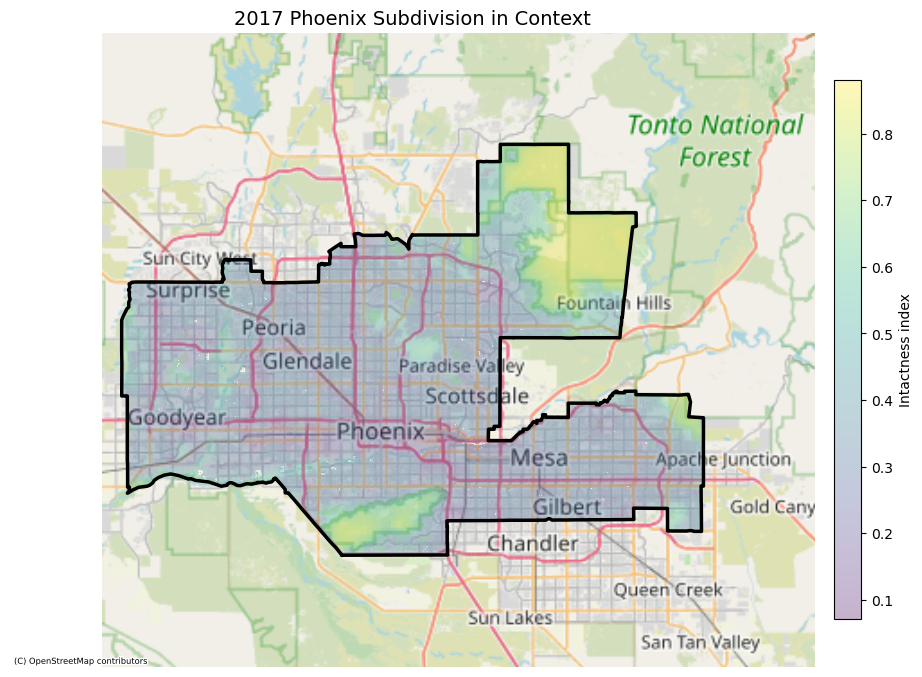

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
# Phoenix subdivision boundary
phoenix.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=2.5,
    label="Phoenix subdivision",
)

# Biodiversity data
phoenix_clip.isel(time=0).plot(
    ax=ax,
    cmap="viridis",
    add_colorbar=True,
    alpha=0.3,
    zorder=0.1,
    cbar_kwargs={
        "label": "Intactness index",
        "shrink": 0.7,
        "pad": 0.02,
    }
)

# Base map
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=9, attribution_size=6)

xmin, ymin, xmax, ymax = phoenix.total_bounds
pad = 19000
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_title("2017 Phoenix Subdivision in Context", fontsize=14)
ax.set_axis_off()
plt.tight_layout()

We can see in 2017 two areas of Phoenix have especially high Biodiversity intactness. In the top right, near Tonto National Forest, and just below the city of Phoenix. Keep these areas in mind as we go on to calculate change in biodiversity intactness.

## Analyzing BII
We want to see how much land with Biodiversity intactness greater than 75% was lost between 2017 and 2020. To make it easy to find percentages for all years, we will make a function. Then we can create a mask where BII is greater than 75% and plot the change. 

1. Percentage of area with BII ≥ 0.75

Our function masks cells ≥ threshold, counts them, and divides by the number of valid (non-NaN) cells for that time slice. Because the data are already clipped to Phoenix, the denominator is the Phoenix area only.

In [49]:
def pct_ge_threshold(da, thr=0.75):
    mask = da >= thr
    valid = da.notnull()
    pct = (mask.sum() / valid.sum() * 100).item()
    return pct

2. Percentages for 2017 and 2020

Select the annual slices, compute the mask-based percentage with our function, and print results.

In [68]:
bii_2017 = phoenix_clip.sel(time="2017-01-01T00:00:00")
bii_2020 = phoenix_clip.sel(time="2020-01-01T00:00:00")

pct_2017 = pct_ge_threshold(bii_2017, thr=0.75)
pct_2020 = pct_ge_threshold(bii_2020, thr=0.75)
decline = pct_2017 - pct_2020


print(f"Phoenix area with BII ≥ 0.75 in 2017: {pct_2017:.2f}%")
print(f"Phoenix area with BII ≥ 0.75 in 2020: {pct_2020:.2f}%")

print(f"Thats a reduction of {decline:.2f}% in only 4 years.")

Phoenix area with BII ≥ 0.75 in 2017: 7.15%
Phoenix area with BII ≥ 0.75 in 2020: 6.52%
Thats a reduction of 0.63% in only 4 years.


3. Percentages for all four years (2017–2020)

Group by year and apply the function to each annual slice. This produces a tidy pandas Series to use for plotting. 

In [51]:
pct_series = (
    phoenix_clip
    .groupby(phoenix_clip["time"].dt.year)
    .map(lambda da: (da >= 0.75).sum() / da.notnull().sum() * 100)
    .to_pandas()
)
pct_series.name = "BII ≥ 0.75 (%)"
pct_series

year
2017    7.150587
2018    6.910991
2019    6.858954
2020    6.515840
Name: BII ≥ 0.75 (%), dtype: float64

4. Plot the change 2017–2020

A simple line plot showing the percent of Phoenix with BII ≥ 0.75 for each year.

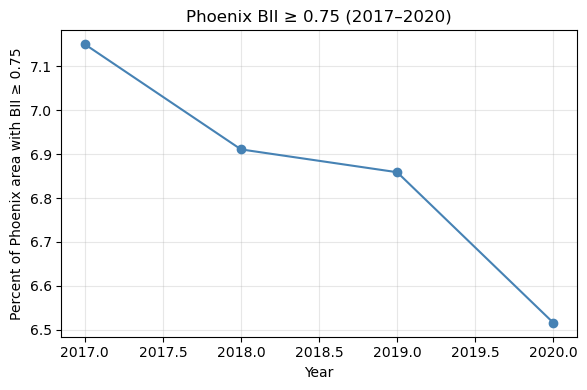

In [52]:
fig, ax = plt.subplots(figsize=(6,4))
pct_series.plot(ax=ax, marker='o', color='steelblue')
ax.set_ylabel('Percent of Phoenix area with BII ≥ 0.75')
ax.set_xlabel('Year')
ax.set_title('Phoenix BII ≥ 0.75 (2017–2020)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Visualizing analysis results
In order to visualize how much land area with BII >= 0.75 was lost over the four years. To do so we have to create masks of BII cells ≥ 0.75 using basic Boolean operations for the 2017 and 2020 slices we made earlier to calculate percentages. 

In [ ]:
mask_2017 = bii_2017 >= 0.75
mask_2020 = bii_2020 >= 0.75

Then we can make our loss mask by taking cells that met the threshold in 2017 but dropped below it in 2020.

In [ ]:
loss_mask = mask_2017 & ~mask_2020

Now lets plot the loss mask over our clipped 2020 intactness raster to see where the land was that lost significant BII.

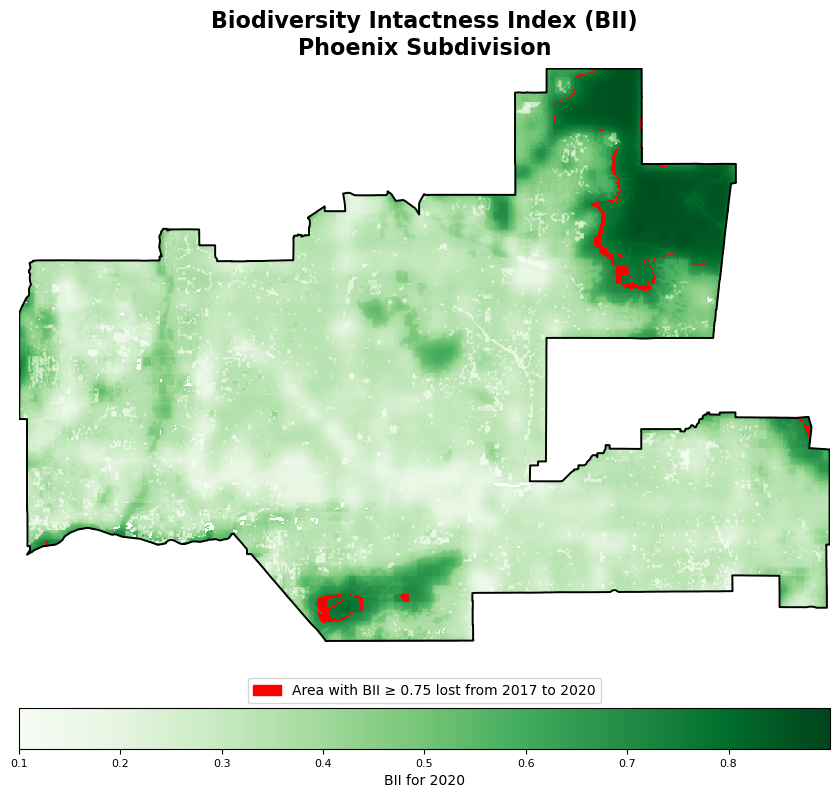

In [63]:
red_cmap = ListedColormap(["r"])
   
fig, ax = plt.subplots(figsize=(8.5, 9))

im = bii_2020.plot(
    ax=ax,
    cmap="Greens",
    vmin=0.1,
    vmax=0.9,
    add_colorbar=False,
    zorder=1,
)

loss_plot = loss_mask.where(loss_mask)
loss_plot.plot(
    ax=ax,
    cmap=red_cmap,
    add_colorbar=False,
    alpha=1.0,
    edgecolor="none",
    linewidth=0,
    zorder=3,
)

phoenix.boundary.plot(ax=ax, 
                      edgecolor="black", 
                      linewidth=1.4, 
                      zorder=4)

legend_elements = [patch.Patch(facecolor='red', 
                               edgecolor='r',
                    label='Area with BII ≥ 0.75 lost from 2017 to 2020')]

ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=5
)

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", 
                               pad=0.08, 
                               fraction=0.05)
cbar.set_label("BII for 2020")
cbar.set_ticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
cbar.ax.xaxis.set_tick_params(labelsize=8)

ax.set_title("Biodiversity Intactness Index (BII)\nPhoenix Subdivision", 
             fontsize=16, 
             fontweight="bold", 
             pad=10)
ax.set_axis_off()
plt.tight_layout()

## Results
Across the Phoenix subdivision, the amount of area with BII ≥ 0.75 declined by 0.63% between 2017 and 2020. Mapping the 2020 BII overlaid with the loss mask reveals three localized pockets-mostly near Tonto National Forest, and just below the city of Phoenix—where BII fell below 0.75 between 2017 and 2020. The percentage metrics and loss visualization together show a modest but spatially clustered drop in high-BII areas over the four-year period.